# MSIN0166 Group Coursework

#Data Engineering for Environmental Insight: Deforestation in Indonesia


Word Count : 4000

Team Members:

* Alessandra Cerutti, Student ID : 23228473
* Amita Sujith, Student ID : 23153341   
* Nefeli Zampeta Marketou, Student ID : 23165493
* Kevin Hayes, Student ID : 23146448
* Rowan Alexander, Student ID : 23226266

# Table of Contents
1. [Introduction](#Introduction)
   1. [Business Problem](#Business-Problem)
   2. [Objective](#Objective)
2. [Architecture](#Architecture)
3. [Extract Data](#Extract-Data)
   1. [Forest Net Data](#Forest-Net-Data)
   2. [Regions Data](#Regions-Data)
   3. [Weather Data](#Weather-Data)
4. [EDA](#EDA)
   1. [EDA on ForestNet](#EDA-on-ForestNet)
   2. [Weather EDA](#Weather-EDA)
5. [Load](#Load)
   1. [Load forest net csv into postgres](#Load-forest-net-csv-into-postgres)
   2. [Load image into bucket](#Load-image-into-bucket)
   3. [Load weather into postgres](#Load-weather-into-postgres)
6. [Transform](#Transform)




<a id="Introduction"></a>
## 1. Introduction




<p>&nbsp;</p>

####1.1 Business Problem
Over the last decades, Indonesia's forest cover has shown significantly high deforestation rates, with only 64% of the forest remaining compared to the original (DGB Group 2024). Indonesia's deforestation resulted in greenhouse emissions that account for 6-8% of global emissions (RAN 2024). Carbon emissions have also been proven to increase temperatures and rainfalls (Risser 2024). Hence, there is a critical and timely need to monitor and understand the dynamics of deforestation and its effects on climate.




<p>&nbsp;</p>



<a id="Objective"></a>
#### 1.2 Objective
The project seeks to develop a scalable data pipeline for extracting and transforming deforestation and weather data, offering insights into their correlation through visualization. It uses a versatile storage approach for flexibility, revealing patterns between Indonesia's deforestation and climate change. This infrastructure supports advanced analysis, machine learning, and organizing and visualizing data for environmental studies.  
  






In [ ]:
# Skip this block if you are running on local computer
# connection with google drive
#from google.colab import drive
#drive.mount('/content/drive')
#from google.colab import files

Mounted at /content/drive


In [64]:
# import libraries and modules needed for the project
from PIL import Image
import pandas as pd   # !pip install pandas pyarrow
import numpy as np
import matplotlib.pyplot as plt
import folium
import geopandas as gpd # !pip install geopandas
import requests   # !pip install requests
#import calendar
import os
from PIL import Image
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster

import seaborn as sns
from shapely.geometry import Point  # merge geodata



# import libraries and modules needed for the project
from PIL import Image
import pandas as pd   # !pip install pandas pyarrow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import requests   # !pip install requests
import calendar
import os
from PIL import Image
import matplotlib.pyplot as plt

from folium.plugins import MarkerCluster
!pip install adjustText
from adjustText import adjust_text



<a id="Architecture"></a>
## 2. Architecture

The diagram illustrates the data pipeline, which streamlines the workflow from data collection to insight generation. The segmentation has been divided into four stages: Extract, Load, Transform (ETL Process), and Visualize.

<img src="data/report/Architecture diagram.png" alt="Architecture" />

<p>&nbsp;</p>

<a id="Extract-Data"></a>
## 3. Extract Data

In this section, we are extracting data on deforestation, including satellite images, their causes, and weather data.


<a id="Forest-Net-Data"></a>
### 3.1 Forest Net Data
The dataset features 2,756 satellite images of deforestation events, each annotated with the cause, such as Plantation or Smallholder Agriculture, based on expert analysis of Global Forest Change maps and high-resolution Google Earth imagery. Landsat 8 satellite images of these events were captured using a cloud-minimizing technique, processed via Descartes Labs. (Irvin et al., 2020)

To facilitate merging weather and deforestation data, the next steps highlight how we create a shared 'province' column in both datasets. The upcoming steps will demonstrate how we utilize province polygons stored in a shapefile to assign a province to each deforestation entry based on their longitude and latitude coordinates.

In [6]:
# Initially, the individual data files comprising the ForestNet dataset are imported.
# import dataframes /content/drive/MyDrive/ForestNetDataset
path_train = 'data/report/data_forest_tabular/train.csv' # '/content/drive/MyDrive/ForestNetDataset/data_forest_tabular/train.csv'
path_test = 'data/report/data_forest_tabular/test.csv' #'/content/drive/MyDrive/ForestNetDataset/data_forest_tabular/test.csv'
path_val =  'data/report/data_forest_tabular/val.csv' #'/content/drive/MyDrive/ForestNetDataset/data_forest_tabular/val.csv'

# Read the files
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)
df_val = pd.read_csv(path_val)

# add a column to each dataframe so that we know their origin
df_train['origin'] = 'train'
df_test['origin'] = 'test'
df_val['origin'] = 'val'

In [7]:
# for better usability merge all dataframes together
df = pd.concat([df_train, df_test, df_val], ignore_index=True)

In [8]:
# Displaying an example of how the data looks
df.head()

label             merged_label  latitude  \
0              Timber plantation               Plantation  4.430849   
1                          Other                    Other  1.332341   
2            Grassland shrubland      Grassland shrubland -1.720266   
3        Small-scale agriculture  Smallholder agriculture -2.248346   
4  Other large-scale plantations               Plantation -2.100800   

    longitude  year                                    example_path origin  
0   96.101634  2014     examples/4.430849118860583_96.1016343478138  train  
1  109.374229  2012  examples/1.3323406178609702_109.37422873130464  train  
2  115.006996  2016  examples/-1.720266384577504_115.00699582064485  train  
3  104.135786  2011   examples/-2.248346072674411_104.1357857482906  train  
4  113.022376  2008   examples/-2.100800102991412_113.0223763234016  train

The dataset provides a framework for analyzing deforestation in Indonesia, with each entry pinpointing a location via latitude and longitude, the year of deforestation, the specific cause of deforestation (`label`). The `merged_label` simplifies these into broader categories, while 'example_path' connects each entry to its satellite image file, organized by coordinates and time, requiring extra steps to access due to its non-relational file structure.

The map below depicts the geo-coordinates for which we have the relevant deforestation data for :

In [21]:
# map centered around the approximate center of Indonesia
map = folium.Map(location=[-2.2151, 115.6628], zoom_start=5)

# Add points to the map
for idx, row in df.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']],
                        radius=3,
                        fill=True).add_to(map)

# Display the map
map

This map displays numerous blue dots spread across the Indonesian archipelago, each representing a specific location of forest loss containted in the dataset. The data is concentrated on the islands of Sumatra, Borneo, and Papua, presumably indicating higher deforestation activities in these regions.

<a id="Regions-Data"></a>
### 3.2 Regions Data

The regions dataset, sourced from MIT GeoData (2015), details geographical areas with attributes like coordinates and provincial boundaries to enable the analysis of deforestation by matching locations with provinces.

In [10]:
# Load the regions dataset as a GeoDataFrame
regions = gpd.read_file('data/report/provinces_report/BATAS_PROVINSI_DESEMBER_2019_DUKCAPIL.shp')

In [12]:
# Convert the DataFrame to a GeoDataFrame to then match the coordinates with the regions
gdf = gpd.GeoDataFrame( # converting the df to geodf
    df, geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)])

In [13]:
gdf.head()

label             merged_label  latitude  \
0              Timber plantation               Plantation  4.430849   
1                          Other                    Other  1.332341   
2            Grassland shrubland      Grassland shrubland -1.720266   
3        Small-scale agriculture  Smallholder agriculture -2.248346   
4  Other large-scale plantations               Plantation -2.100800   

    longitude  year                                    example_path origin  \
0   96.101634  2014     examples/4.430849118860583_96.1016343478138  train   
1  109.374229  2012  examples/1.3323406178609702_109.37422873130464  train   
2  115.006996  2016  examples/-1.720266384577504_115.00699582064485  train   
3  104.135786  2011   examples/-2.248346072674411_104.1357857482906  train   
4  113.022376  2008   examples/-2.100800102991412_113.0223763234016  train   

                     geometry  
0    POINT (96.10163 4.43085)  
1   POINT (109.37423 1.33234)  
2  POINT (115.00700 -1.72027)  
3  POINT (104.13579 -2.24835)  
4  POINT (113.02238 -2.10080)

In [14]:
# Display the initial number of rows in the regions dataset
num_rows = regions.shape[0]
print(f"The number of Provinces is: {num_rows}")

The number of Provinces is: 34


In [15]:
# Perform the spatial join to match deforestation points with their corresponding provinces
#gdf = gpd.sjoin(gdf, boroughs, how="left", op='within')
gdf = gpd.sjoin(gdf, regions, how="left", op='within')

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/vg/nl_vpfpd3f96h8h8tbd78lw40000gn/T/ipykernel_55338/414730185.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, regions, how="left", op='within')


In [16]:
# Rename the 'PROVINSI' column to 'province' for clarity
gdf = gdf.rename(columns={'PROVINSI': 'province'})

In [17]:
# Display the initial number of rows after the join
num_rows = gdf.shape[0]
print(f"After the join, the number of rows is: {num_rows}")

After the join, the number of rows is: 2757


In [18]:
# Drop columns not needed
gdf.drop(['index_right', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'geometry'], axis=1, inplace=True)

In [19]:
# Make all the regions name lower case for clarirty
gdf['province'] = gdf['province'].str.lower()

gdf.head()

label             merged_label  latitude  \
0              Timber plantation               Plantation  4.430849   
1                          Other                    Other  1.332341   
2            Grassland shrubland      Grassland shrubland -1.720266   
3        Small-scale agriculture  Smallholder agriculture -2.248346   
4  Other large-scale plantations               Plantation -2.100800   

    longitude  year                                    example_path origin  \
0   96.101634  2014     examples/4.430849118860583_96.1016343478138  train   
1  109.374229  2012  examples/1.3323406178609702_109.37422873130464  train   
2  115.006996  2016  examples/-1.720266384577504_115.00699582064485  train   
3  104.135786  2011   examples/-2.248346072674411_104.1357857482906  train   
4  113.022376  2008   examples/-2.100800102991412_113.0223763234016  train   

            province  
0               aceh  
1   kalimantan barat  
2  kalimantan tengah  
3   sumatera selatan  
4  kalimantan tengah

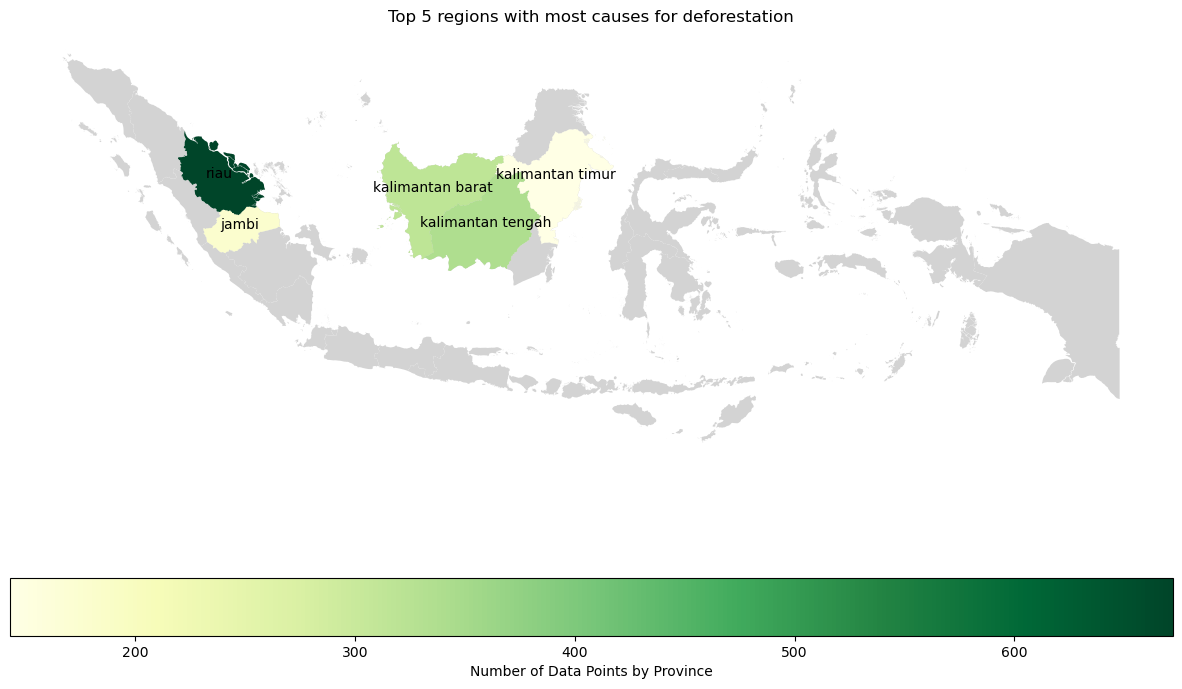

In [20]:
# Regions Map
indonesia_map = regions
indonesia_map['province'] = indonesia_map['PROVINSI'].str.lower()

# Aggregate your data points by province
province_counts = gdf['province'].value_counts().reset_index()
province_counts.columns = ['province', 'data_point_count']

# Sort and get the top five provinces
top_provinces = province_counts.nlargest(5, 'data_point_count')

# Merge the shapefile with your data points count
map_with_data = indonesia_map.merge(top_provinces, on='province', how='left')


# Plot the map with all provinces
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
indonesia_map.plot(ax=ax, color='lightgrey')  # This will plot all provinces in a light grey color

# Now plot the provinces with data on top
map_with_data.plot(column='data_point_count', ax=ax, legend=True,
                   legend_kwds={'label': "Number of Data Points by Province",
                                'orientation': "horizontal"},
                   cmap='YlGn')

# Annotate only the top five provinces
for idx, row in map_with_data.iterrows():
    if pd.notnull(row['data_point_count']) and row['province'] in top_provinces['province'].values:
        plt.annotate(text=row['province'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                     horizontalalignment='center', fontsize=10, color='black')

plt.title("Top 5 regions with most causes for deforestation", fontdict=None, loc='center', pad=None)

# Remove the axis for a cleaner look and display the map
plt.axis('off')
plt.show()


<a id="Weather-Data"></a>
### 3.3 Weather Data

For our weather data, we decided to utilise Visual Crossing's API  (a low-cost, easy-to-use weather API that allows users to obtain weather data from any GPS coordinate). An API is preferable to an online CSV for our deforestation dashboard because it offers real-time access to updated weather information, which is necessary for having up-to-date data. Given the budget constraints and the project scope, we included only historical weather data.


The variables of interest are average rainfall and temperature, which are necessary for understanding deforestation impacts such as forest fires and droughts. We wanted a broad timeframe to offer insights into long-term climate trends, which is essential for assessing the impact of climate change.

Initially, we registered for Visual Crossing, obtaining an API key for data requests. When crafting the query, we had two options for specifying location: GPS coordinates or address. We opted to provide a GPS coordinate of a central point in each province provided by Geokeo (https://geokeo.com/database/state/id/). We recognised that weather there might not fully represent the entire province or deforestation areas. Nevertheless, with 38 provinces in Indonesia, we deemed province-level granularity sufficient to mitigate errors. We iterated through the provinces and years to retrieve data and then saved it as a CSV.



#### 3.3.1 Integrating The API into the pipeline

For seamless integration with Docker and the weather API, we create a standalone Python script to retrieve and save the weather data. Furthermore, the script has been adapted to receive the API key through the terminal, bolstering security while providing greater adaptability. The code below is  an example of the script, which is saved as weather_data_processor.py on our Github repository. Please note that the system was originally designed to save the output as .csv and parquet files directly to Google Drive.

In [ ]:
# Retrieve API key from environment variables
API_KEY = os.getenv('VISUAL_CROSSING_API_KEY')
# Check if API key is available, if not raise an error
if not API_KEY:
    raise ValueError("No API Key found. Set the VISUAL_CROSSING_API_KEY environment variable.")

# Base URL for Visual Crossing Weather API
BASE_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

# Define the range of years for which to fetch weather data
start_year = 2002
end_year = 2016

# Initialize an empty list to store the data
data = []

# Define the list of provinces with their names and geographic coordinates
provinces = [
    {"name": "Riau", "latitude": 0.5004112, "longitude": 101.5475811},
    {"name": "Central Kalimantan", "latitude": -1.499583, "longitude": 113.2903307},
    {"name": "West Kalimantan", "latitude": -0.1322387, "longitude": 111.0968901},
    {"name": "Jambi", "latitude": -1.611572, "longitude": 102.779699},
    {"name": "East Kalimantan", "latitude": 0.7884397, "longitude": 116.2419977},
    {"name": "North Sumatra", "latitude": 2.1923519, "longitude": 99.3812201},
    {"name": "North Kalimantan", "latitude": 3.0235817, "longitude": 116.2049306},
    {"name": "Papua", "latitude": -3.9885728, "longitude": 138.3485219},
    {"name": "Central Sulawesi", "latitude": -1.6937786, "longitude": 120.8088555},
    {"name": "West Sumatra", "latitude": -0.5827529, "longitude": 100.6133379},
    {"name": "Aceh", "latitude": 4.3685491, "longitude": 97.0253024},
    {"name": "Southeast Sulawesi", "latitude": -3.5491199, "longitude": 121.7279646},
    {"name": "South Sumatra", "latitude": -3.1266842, "longitude": 104.0930554},
    {"name": "West Papua", "latitude": -1.3842356, "longitude": 132.902528},
    {"name": "North Maluku", "latitude": 0.6301215, "longitude": 127.9720219},
    {"name": "Bangka Belitung Islands", "latitude": -2.7410513, "longitude": 106.4405872},
    {"name": "South Kalimantan", "latitude": -2.9285686, "longitude": 115.3700718},
    {"name": "West Sulawesi", "latitude": -2.4974546, "longitude": 119.3918955},
    {"name": "South Sulawesi", "latitude": -3.6446718, "longitude": 119.9471906},
    {"name": "Bengkulu", "latitude": -3.5186763, "longitude": 102.5359834},
    {"name": "Maluku", "latitude": -3.118837, "longitude": 129.4207759},
    {"name": "Gorontalo", "latitude": 0.7186174, "longitude": 122.4555927},
    {"name": "North Sulawesi", "latitude": 0.6555692, "longitude": 124.090151},
    {"name": "Lampung", "latitude": -4.8555039, "longitude": 105.0272986},
    {"name": "East Java", "latitude": -7.6977397, "longitude": 112.4914199},
    {"name": "Riau Islands", "latitude": -0.1547846, "longitude": 104.5803745},
    {"name": "West Java", "latitude": -6.8891904, "longitude": 107.6404716},
    {"name": "Banten", "latitude": -6.4453801, "longitude": 106.1375586},
    {"name": "West Nusa Tenggara", "latitude": -8.6529334, "longitude": 117.3616476},
]

# Loop over each province and year to fetch weather data
for province in provinces:
    for year in range(start_year, end_year + 1):
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"

        # Create the location string from the latitude and longitude
        location = f"{province['latitude']},{province['longitude']}"
        # Construct the URL for the API request
        url = f"{BASE_URL}{location}/{start_date}/{end_date}?unitGroup=metric&key={API_KEY}&include=days"

        # Make the API request
        response = requests.get(url)
        # Check if the request was successful
        if response.status_code == 200:
            yearly_data = response.json()
            # Calculate the total rainfall for the year
            total_rainfall = sum(day.get('precip', 0) for day in yearly_data.get('days', []) if day.get('precip') is not None)

            # Calculate the average temperature for the year
            valid_temps = [day.get('temp') for day in yearly_data.get('days', []) if day.get('temp') is not None]
            if valid_temps:  # Check if the list is not empty
                avg_temp = sum(valid_temps) / len(valid_temps)
            else:
                avg_temp = None  # Placeholder value indicating no data

            # Append the results to the data list
            data.append({
                "Province": province['name'],
                "Year": year,
                "Average Temperature (°C)": avg_temp,
                "Total Rainfall (mm)": total_rainfall,
            })
            print(f"Processed {province['name']} for {year}")
        else:
            print(f"Failed to retrieve data for {province['name']} for {year}. Status code: {response.status_code}")

# Convert the data list into a pandas DataFrame
df = pd.DataFrame(data)

# Group by province and year, then calculate mean temperature and rainfall
grouped = df.groupby(['Province', 'Year']).agg({
    'Average Temperature (°C)': 'mean',
    'Total Rainfall (mm)': 'mean'
}).reset_index()

# Pivot the table for average temperature
avg_temp_pivot = grouped.pivot(index='Province', columns='Year', values='Average Temperature (°C)')
avg_temp_pivot.columns = [f'{col} Average Temp' for col in avg_temp_pivot.columns]

# Pivot the table for total rainfall
avg_rain_pivot = grouped.pivot(index='Province', columns='Year', values='Total Rainfall (mm)')
avg_rain_pivot.columns = [f'{col} Average Rain' for col in avg_rain_pivot.columns]

# Join the pivoted tables
result = avg_temp_pivot.join(avg_rain_pivot).reset_index()

# Define the CSV file path where the result will be saved
csv_file_path = "data_weather/historical_weather_data_annual.csv"
# Save the result to a CSV file
result.to_csv(csv_file_path, index=False)

# Print completion message with the CSV file path
print(f"Data saved to {csv_file_path}")

In [ ]:
#Change to parquet file
uploaded = files.upload()

csv_file = 'historical_weather_data_annual.csv'
df = pd.read_csv(csv_file)

parquet_file = 'historical_weather_data_annual.parquet'
df.to_parquet(parquet_file, index=False)

files.download(parquet_file)

#### 3.3.2 Docker integration

Docker streamlines the creation, deployment, and running of applications by enclosing them in containers with their dependencies, guaranteeing consistent functionality on diverse Linux systems and facilitating easier deployments. To manage project dependencies, a requirements.txt file enumerates all necessary Python packages, simplifying installation during environment setup. Additionally, a Dockerfile has been meticulously prepared, providing step-by-step instructions to construct the Docker image, which includes selecting a base image, designating the working directory, transferring essential files, installing dependencies specified in requirements.txt, and defining the execution command for the script.

Commands were executed in the Terminal to build the Docker image and run the container. The process of building the image utilised a Docker command referencing the Dockerfile, while running the container involved setting the API key through an environment variable and mounting a volume for the CSV output.

<img src="data/report/Screenshots/docker1.jpeg" alt="docker1" />

<img src="data/report/Screenshots/docker2.jpeg" alt="docker1" />

<img src="data/report/Screenshots/docker3.jpeg" alt="docker1" />

<img src="data/report/Screenshots/docker4.jpeg" alt="docker1" />

<a id="EDA"></a>
## 4. Exploratory Data Analysis

<a id="EDA-on-ForestNet"></a>
### 4.1 EDA on ForestNet

Following part is the Exploratory Data Analysis (EDA) of the forest dataset can reveal key spatial and temporal trends, aiding in the assessment of the deforestation causes.

The early EDA focused on revealing the connections between provinces, time, and deforestation causes

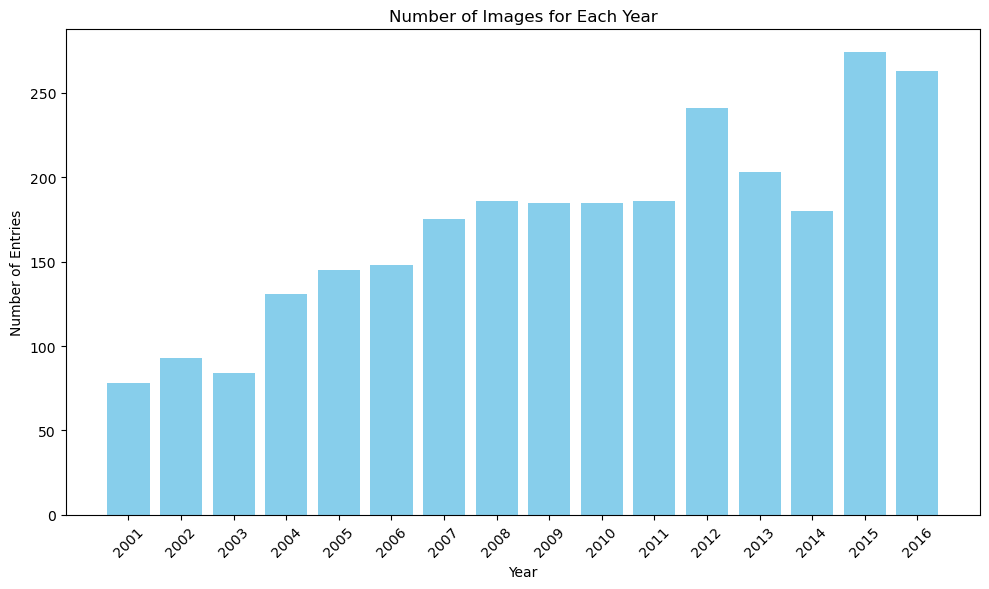

In [23]:
# Assuming 'unique_years' is already defined
# Extract all the different datasets from the dataset
unique_years = df['year'].unique()

# Put the years in ascending order
unique_years.sort()

# Count the number of entries for each year
entry_counts = [len(df[df['year'] == year]) for year in unique_years]

# Plotting
plt.figure(figsize=(10, 6), facecolor = 'none', edgecolor='none')
plt.bar(unique_years, entry_counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Images for Each Year')
plt.grid(False)
plt.xticks(unique_years, rotation=45)
plt.tight_layout()
plt.show()


In [24]:
#Calculating the total number of unique data points

# Create a set of tuples where each tuple is a unique location (latitude, longitude)
unique_locations = set(zip(df['latitude'], df['longitude']))

# Convert the set back to a list
unique_locations_list = list(unique_locations)

# Print the first few locations to verify
#print(unique_locations_list[:5])

# Count the number of unique loications on the dataframe
number_of_unique_locations = len(unique_locations)

# Display the number of unique locations
print("Total unique locations:", number_of_unique_locations)


Total unique locations: 2757


This bar graph below show the distribution of deforestation causes. Oil palm plantations are the leading cause with 599 entries, followed closely by small-scale agriculture at 576, with other factors like timber plantations, grassland shrubland, and mining contributing to a lesser extent.

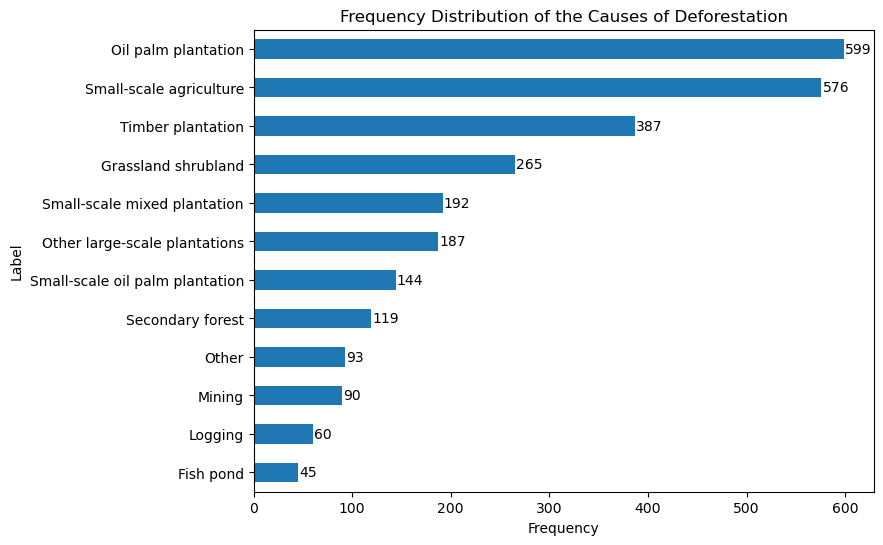

In [25]:
# Calculate the frequency distribution of the 'label' column
label_counts = df['label'].value_counts().sort_values(ascending=True)  # Sort from smallest to largest

# Plotting the frequency distribution as a horizontal bar chart
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='barh')  # Use 'barh' for horizontal bar chart
plt.title('Frequency Distribution of the Causes of Deforestation')
plt.xlabel('Frequency')
plt.ylabel('Label')
ax.set_facecolor('none')  # Set the axes background to transparent

# Iterate over the bars and add text labels
for i, v in enumerate(label_counts):
    ax.text(v + 1, i, str(v), color='black', va='center')

plt.show()

In [26]:
#Causes and locations

# Create a base map
map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5, tiles='cartodbpositron')

# Optional: Use MarkerCluster to cluster close markers together
marker_cluster = MarkerCluster().add_to(map)

# Define a fixed list of colors
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Generate a color for each unique 'merged_label'
unique_labels = df['merged_label'].unique()
color_dict = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

# Add markers to the map, ensuring different colors for each 'merged_label'
for _, row in df.iterrows():
    icon_color = color_dict.get(row['merged_label'], 'lightgray')  # Default to 'lightgray' if no match
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Cause: {row['merged_label']}",
        icon=folium.Icon(color=icon_color)
    ).add_to(marker_cluster)

# Display the map
map


<a id="EDA-on-ForestNet"></a>


### 4.2 EDA on Weather Data





In [67]:
# Read the CSV file into a DataFrame
weather_data = pd.read_csv("data/report/data_weather/combined_weather_data.csv")

weather_data.head()

province  year  average_temp  average_rain
0                     Aceh  2001           NaN         0.000
1  Bangka Belitung Islands  2001     26.933688      2757.200
2                   Banten  2001     27.213151      2459.296
3                 Bengkulu  2001     26.818207      2255.800
4       Central Kalimantan  2001           NaN         0.000

In [68]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   province      464 non-null    object 
 1   year          464 non-null    int64  
 2   average_temp  367 non-null    float64
 3   average_rain  464 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 14.6+ KB


There are 29 of Indonesia's provinces in the dataset. Before 2010, there was incomplete average temperature data (as suggested by the lower non-null count).

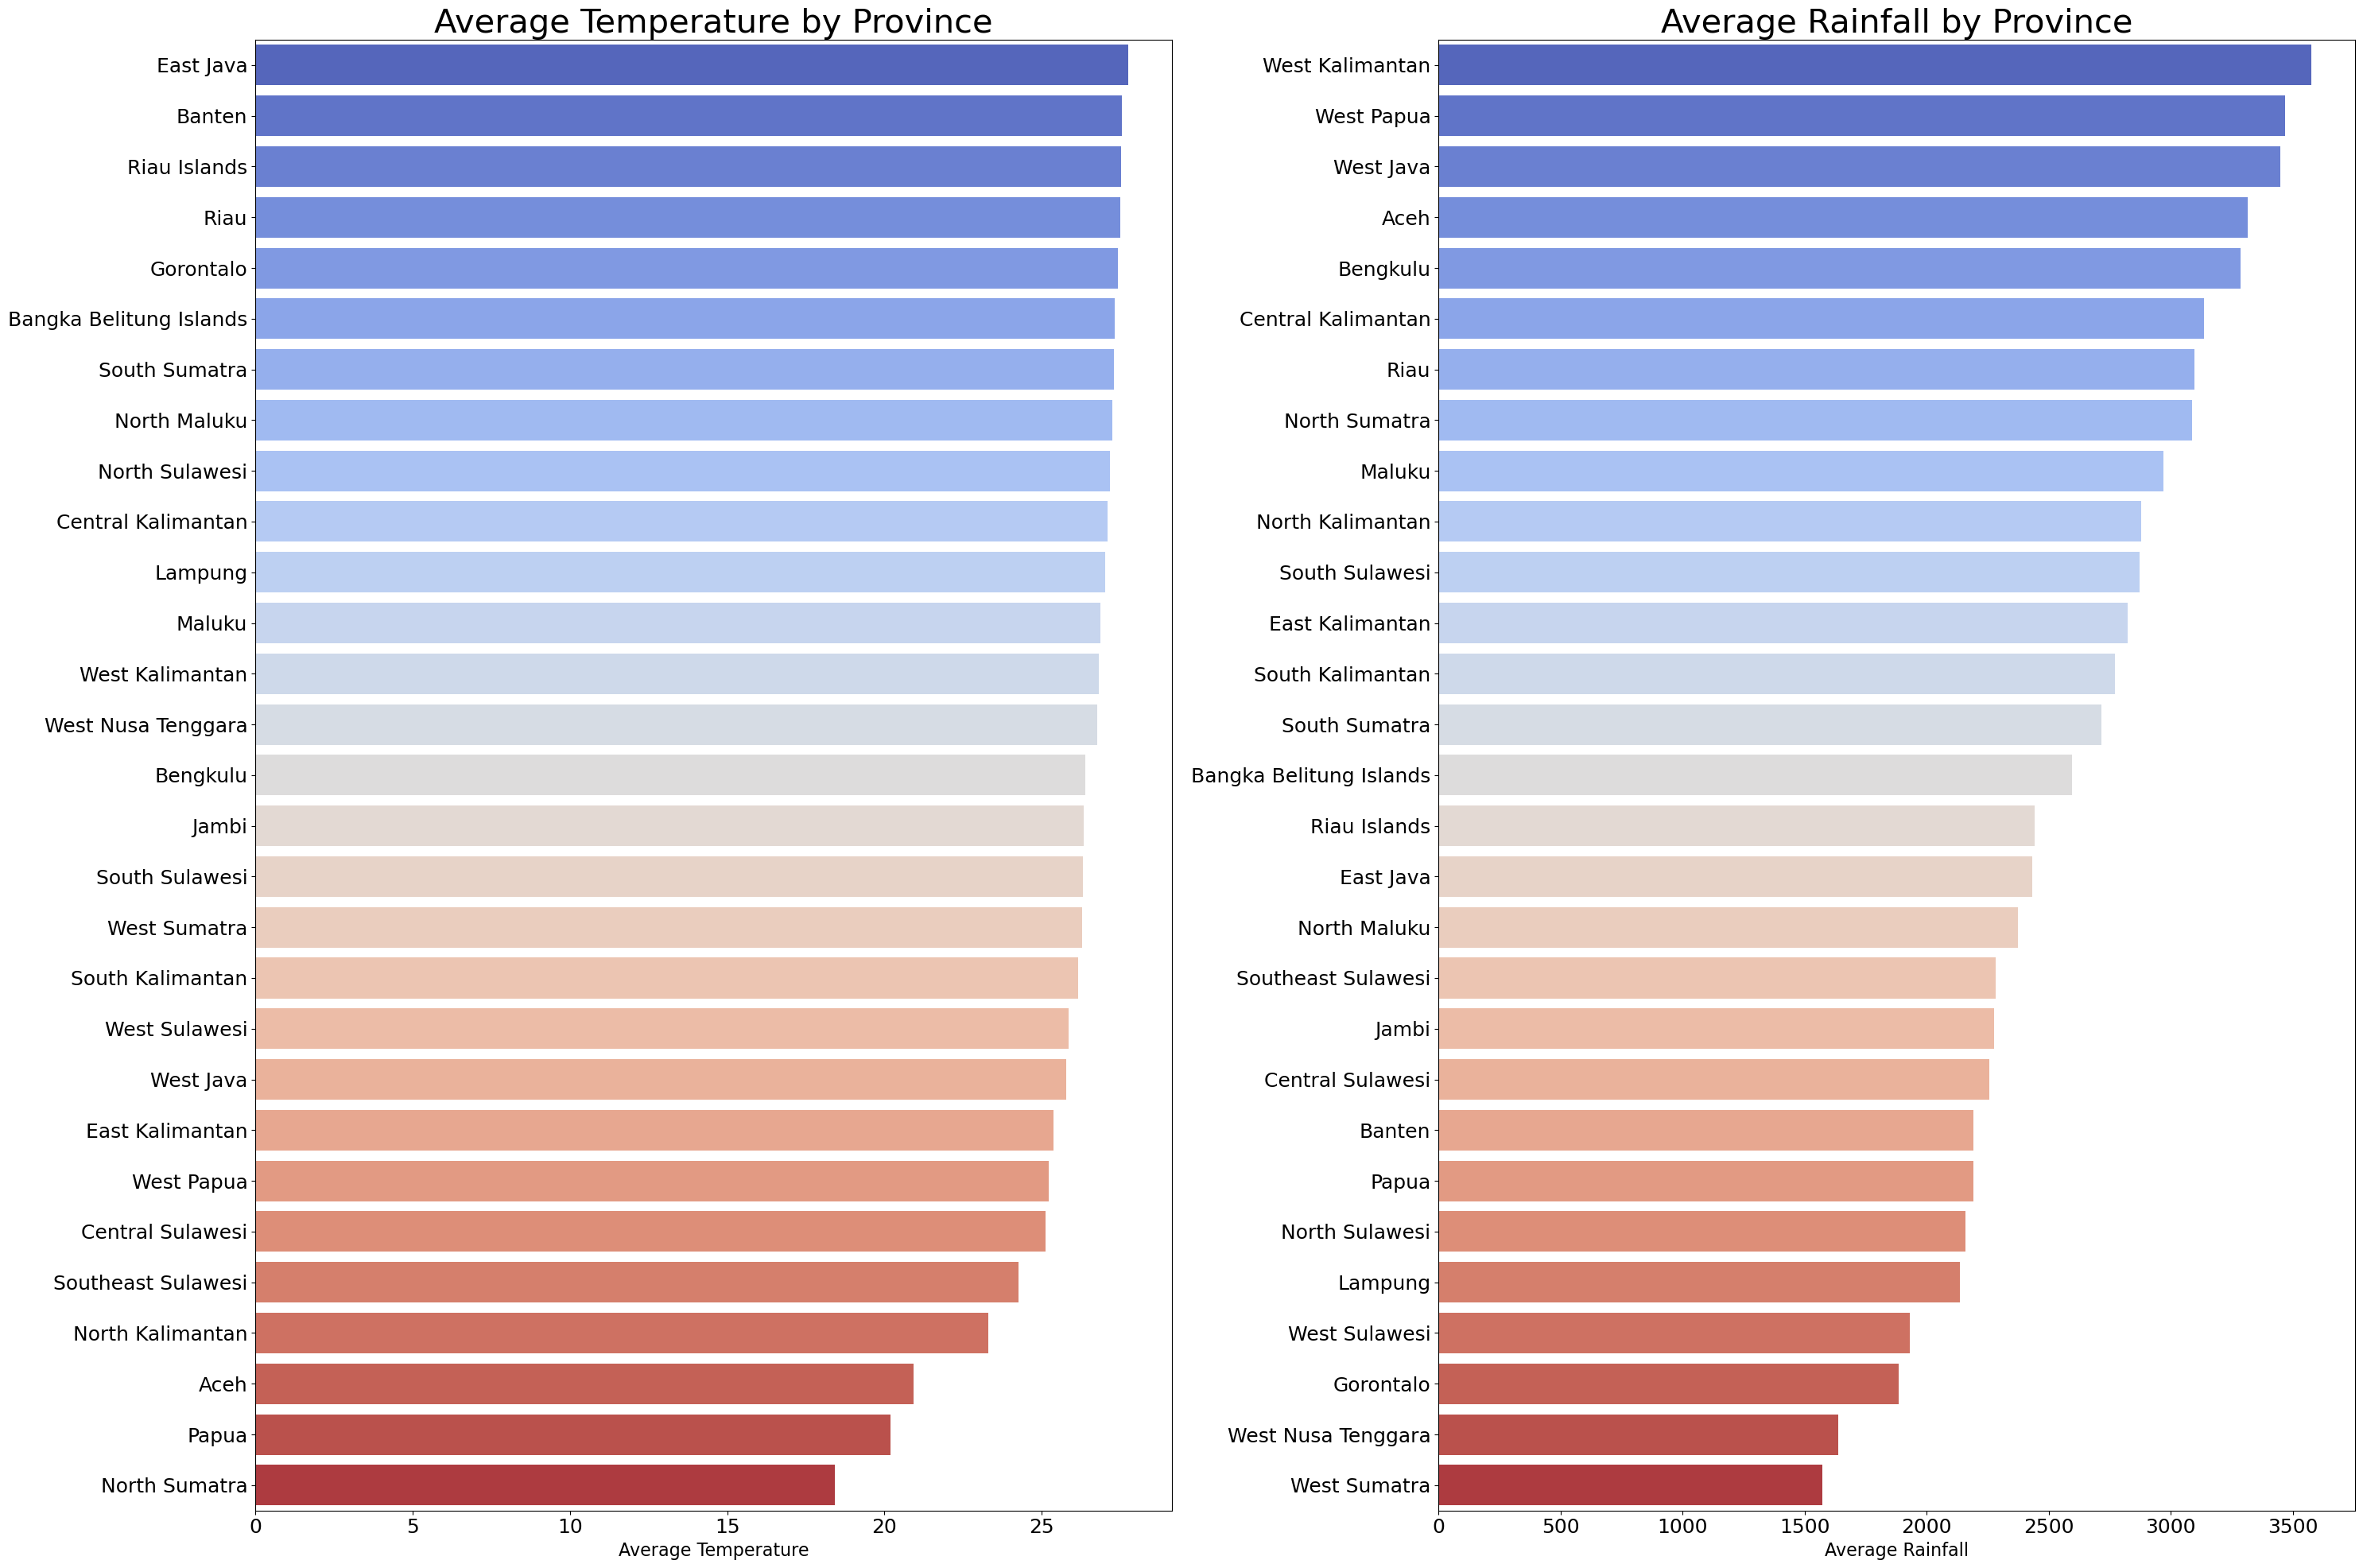

In [58]:
weather_data_cleaned = weather_data.dropna()

# Grouping by Province for temperature and rainfall, then sorting
province_grouped_temp = weather_data_cleaned.groupby('province').mean().reset_index().sort_values(by='average_temp', ascending=False)
province_grouped_rain = weather_data_cleaned.groupby('province').mean().reset_index().sort_values(by='average_rain', ascending=False)

# Visualizing average temperature and average rainfall by province with increased font sizes
plt.figure(figsize=(30, 20))

# Temperature subplot
ax1 = plt.subplot(1, 2, 1)
sns.barplot(x='average_temp', y='province', data=province_grouped_temp, palette='coolwarm')
ax1.set_title('Average Temperature by Province', fontsize=30)
ax1.set_xlabel('Average Temperature', fontsize=16)
ax1.set_ylabel(None)
ax1.tick_params(labelsize=18)

# Rainfall subplot
ax2 = plt.subplot(1, 2, 2)
sns.barplot(x='average_rain', y='province', data=province_grouped_rain, palette='coolwarm')
ax2.set_title('Average Rainfall by Province', fontsize=30)
ax2.set_xlabel('Average Rainfall', fontsize=16)
ax2.set_ylabel(None)
ax2.tick_params(labelsize=18)

plt.tight_layout()
plt.show()


The average temperatures across provinces range from 18.4 degrees in North Sumatra to 27.7 degrees in East Java, while average rainfall spans from 1574mm in West Sumatra to 3576mm in West Kalimantan.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

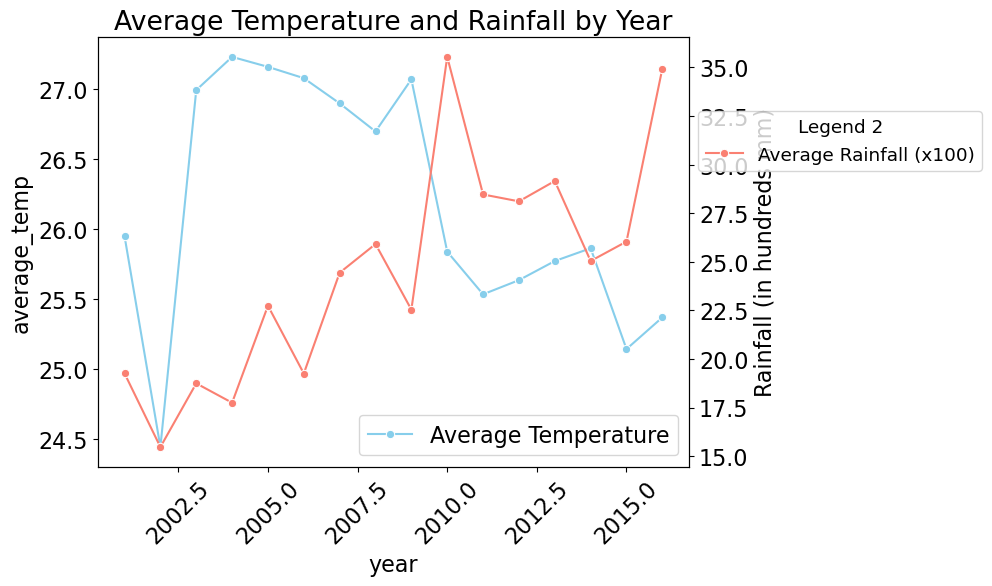

In [65]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Create a line plot for average temperature
sns.lineplot(x='year', y='average_temp', data=year_grouped_temp, marker='o', color='skyblue', label='Average Temperature')

# Set the x-ticks rotation
plt.xticks(rotation=45)

# Create a second y-axis for the average rainfall scaled down
ax2 = plt.twinx()

# Scale the 'average_rain' data to be in the hundreds
year_grouped_rain['average_rain_scaled'] = year_grouped_rain['average_rain'] * 0.01

# Create a line plot for the scaled average rainfall
sns.lineplot(x='year', y='average_rain_scaled', data=year_grouped_rain, marker='o', color='salmon', ax=ax2, label='Average Rainfall (x100)')

# Set the title and labels
plt.title('Average Temperature and Rainfall by Year')
plt.xlabel('Year')
ax2.set_ylabel('Rainfall (in hundreds mm)')

# Place the legends outside of the figure
# For the first legend
legend1 = plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize='small', title="Legend 1")
# Adjust the title size if needed
legend1.get_title().set_fontsize('small')

# For the second legend
legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(1,0.85), fontsize='small', title="Legend 2")
# Adjust the title size if needed
legend2.get_title().set_fontsize('small')

# Adjust layout to make room for the legends outside the plot
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the uploaded CSV has been saved in the path below and has the same structure as the user showed
file_path = '/mnt/data/combined_weather_data.csv'

# Let's read the CSV file into a DataFrame
weather_data = pd.read_csv(file_path)

# Drop rows where 'average_temp' or 'average_rain' is NaN as we can't plot these
weather_data.dropna(subset=['average_temp', 'average_rain'], inplace=True)

# Group the data by year and calculate the mean of 'average_temp' and 'average_rain'
grouped_weather = weather_data.groupby('year').agg({'average_temp': 'mean', 'average_rain': 'mean'}).reset_index()

# Now let's create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Temperature plot
axes[0].plot(grouped_weather['year'], grouped_weather['average_temp'], marker='o', color='skyblue')
axes[0].set_title('Average Temperature by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Temperature (degrees Celsius)')
axes[0].grid(True)

# Rainfall plot
axes[1].plot(grouped_weather['year'], grouped_weather['average_rain'], marker='o', color='salmon')
axes[1].set_title('Average Rainfall by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Rainfall (mm)')
axes[1].grid(True)

plt.tight_layout()
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/combined_weather_data.csv'

Plotting average temperature amd rainfall for all of Indonesia provides interesting results. From 2000 to 2016, average rainfall increased from a low of 1546.78mm in 2002 to 3493.68mm in 2016. In contrast, average temperature peaks around the 27 degrees mark between 2003 and 2009 and then plummets to around 25 degrees from 2010 to 2016.

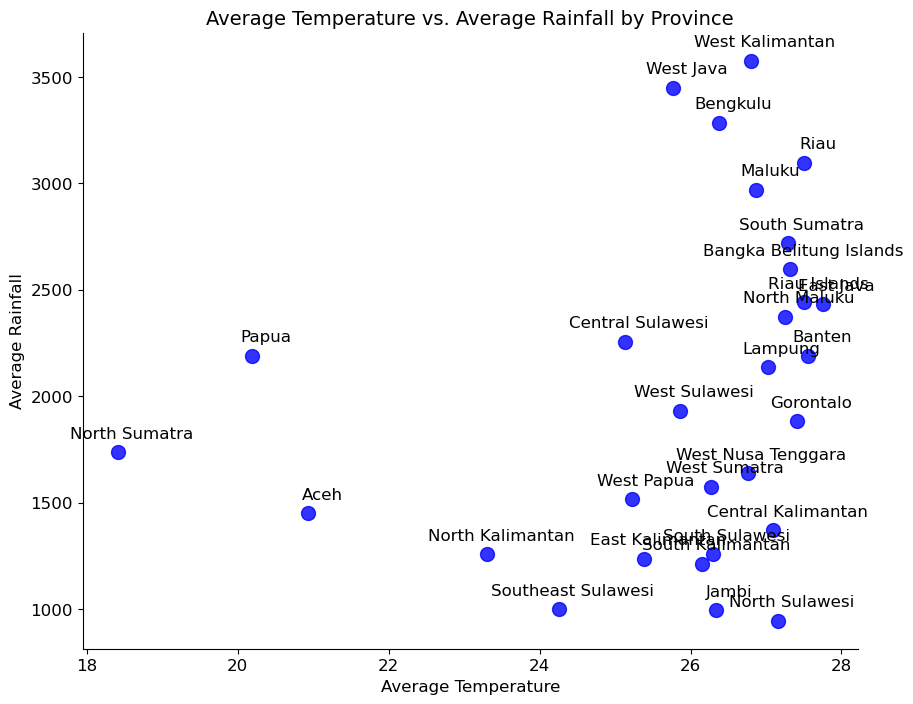

In [47]:
from matplotlib import pyplot as plt

# Calculate the mean values for each province
province_means = weather_data.groupby('province').mean()

# Create the scatter plot with averaged values
plt.figure(figsize=(10, 8))
plt.scatter(x=province_means['average_temp'], y=province_means['average_rain'], s=100, alpha=0.8, color='blue')

# Add province names as annotations
for province, temp, rain in zip(province_means.index, province_means['average_temp'], province_means['average_rain']):
    plt.annotate(province, (temp, rain), textcoords="offset points", xytext=(10, 10), ha='center', fontsize=12)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add labels and title
plt.xlabel('Average Temperature', fontsize = 12)
plt.ylabel('Average Rainfall', fontsize = 12)
plt.title('Average Temperature vs. Average Rainfall by Province', fontsize = 14)
plt.tick_params(labelsize=12)

plt.show()

This is a scatter plot of average rainfall and temperature for all provinces. West Kalimantan stands out as a province that experiences both high temperatures and rainfall. In contrast, North Sumatra stands out as a province that experiences low rainfall and temperatures.

<a id="Load"></a>
## 5. Load

  This project utilizes the Google Cloud Platfrom(GCP) considering that it provides a wide range of effective, easy-to-implement cloud solutions with modern infrastructures(Google Cloud 2024).
  Within the GCP ecosystem, components used for the below pipeline are: Google Cloud Storage buckets and Cloud SQL for PostgreSQL. The choice of Cloud-Based Storage provides inherent scaability as it  enables an easy expansion of IT resources to meet fluctuating demands (VMWARE 2024).


<a id="Load-forest-net-csv-into-postgres"></a>
### 5.1 Load forest net and weather data  into bucket




 Google Cloud Storage buckets have been selected for storing data in the cloud. Buckets enable a centralisation of the data storage which increases the efficiency of the processes, they are a scalable solution for data storage and they ensure flexible and secure accesibility to data (LogicMonitor 2022).

The process involves creating and uploading data into cloud storage buckets in Google Cloud Platform(GCP).
Initially access had to be secured to the GCP services and storage capabilties by authenticating user's credentials.

Two buckets are created:

*   **ucl-forest** - for storing the deforestation data
*   **ucl-weather** - for storing the weather data.

 The corresponding csv files and image data are uploaded to the buckets via python script, by defining a function connecting to the bucket.  Hence after the completion of these steps the buckets serve the purpose of being repositories for storing the datasets.
The above process can be seen on the following github link: https://github.com/acerutti/ucl-forest-weather/blob/main/main.py




**Example of Function for the Bucket Creation**

```
# Instantiates a client
storage_client = storage.Client()

## WEATHER BUCKET ##
# The name for the new bucket for the weather

bucket_name = "ucl-weather"
bucket = storage_client.create_bucket(bucket_name)
print(f"Bucket {bucket.name} created.")
```






To upload files on the bucket, we created two different functions: one for uploading individual files and one for uploading pictures folders.

**Individual Files**
```
def upload_blob(bucket_name, source_file_name, destination_blob_name):
  """Uploads a file to the bucket."""
  storage_client = storage.Client()
  bucket = storage_client.get_bucket(bucket_name)
  blob = bucket.blob(destination_blob_name)

  blob.upload_from_filename(source_file_name)

  print('File {} uploaded to {}.'.format(
      source_file_name,
      destination_blob_name))
```
**Folder with Picture**

This function recursively uploads all files from a specified directory on the local filesystem to a Google Cloud Storage bucket, maintaining the directory structure.
```
def upload_directory_to_bucket(bucket_name, source_directory):
    """Uploads a directory to the bucket."""
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    
    for local_dir, _, files in os.walk(source_directory):
        for file in files:
            local_file_path = os.path.join(local_dir, file)
            
            # Construct the full path for the destination blob
            # Using the folder names as the blob prefix
            relative_path = os.path.relpath(local_file_path, source_directory)
            destination_blob_name = relative_path.replace("\\", "/")  # Ensure proper path format for GCS
            
            blob = bucket.blob(destination_blob_name)
            blob.upload_from_filename(local_file_path)
            
            print(f'File {local_file_path} uploaded to {destination_blob_name}.')
```
For storage costs reasons we only uploaded five folders to the bucket (see Appendix)

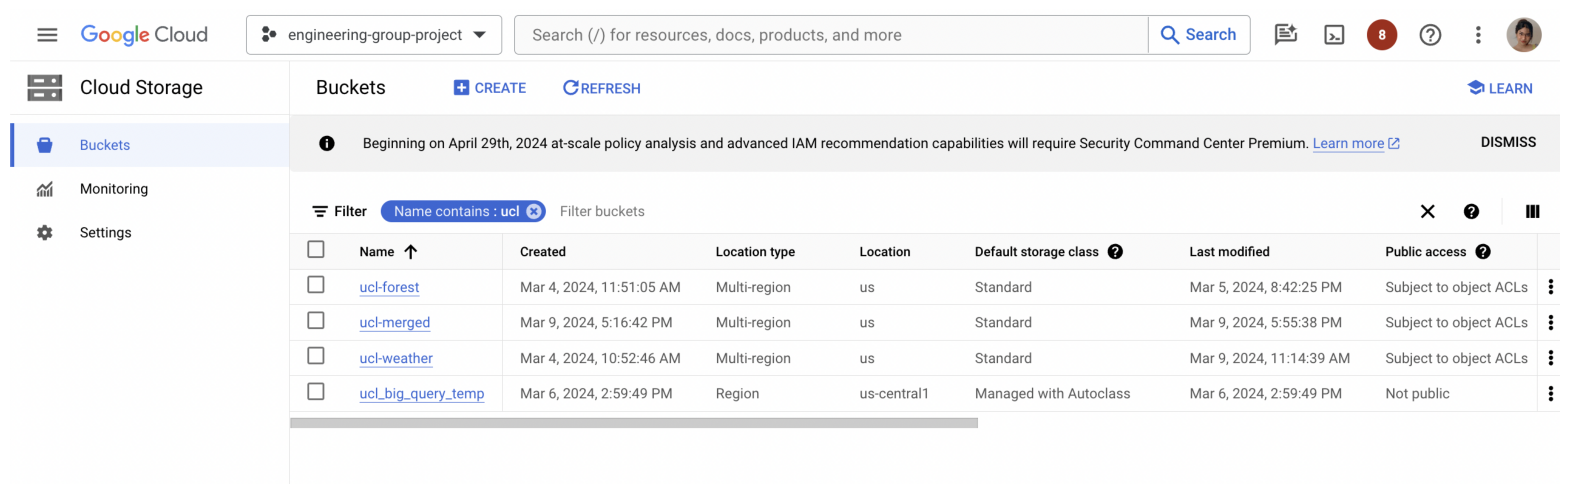

In [ ]:
# The buckets were created
image_1 = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/buckets1.png')
# Set the figure size to a larger value to make the displayed image bigger
plt.figure(figsize=(20, 10))  # Adjust the width and height as needed
# Remove the axis for a cleaner look
plt.axis('off')
# Display the image
plt.imshow(image_1)

<a id="Load-weather-into-postgres"></a>
### 5.2 Connecting Buckets to Postgres in GCP


  Once the data has been loaded into the buckets, we can connect them to CloudSQL - Postgres to create the respective tables for forest and weather data.
  
  PostgreSQL database within GCP is a highly reliable and scalable database system.
  The initial step requires the creation of an instance in PostgreSQL, where a **forestnet-data instance** is created.



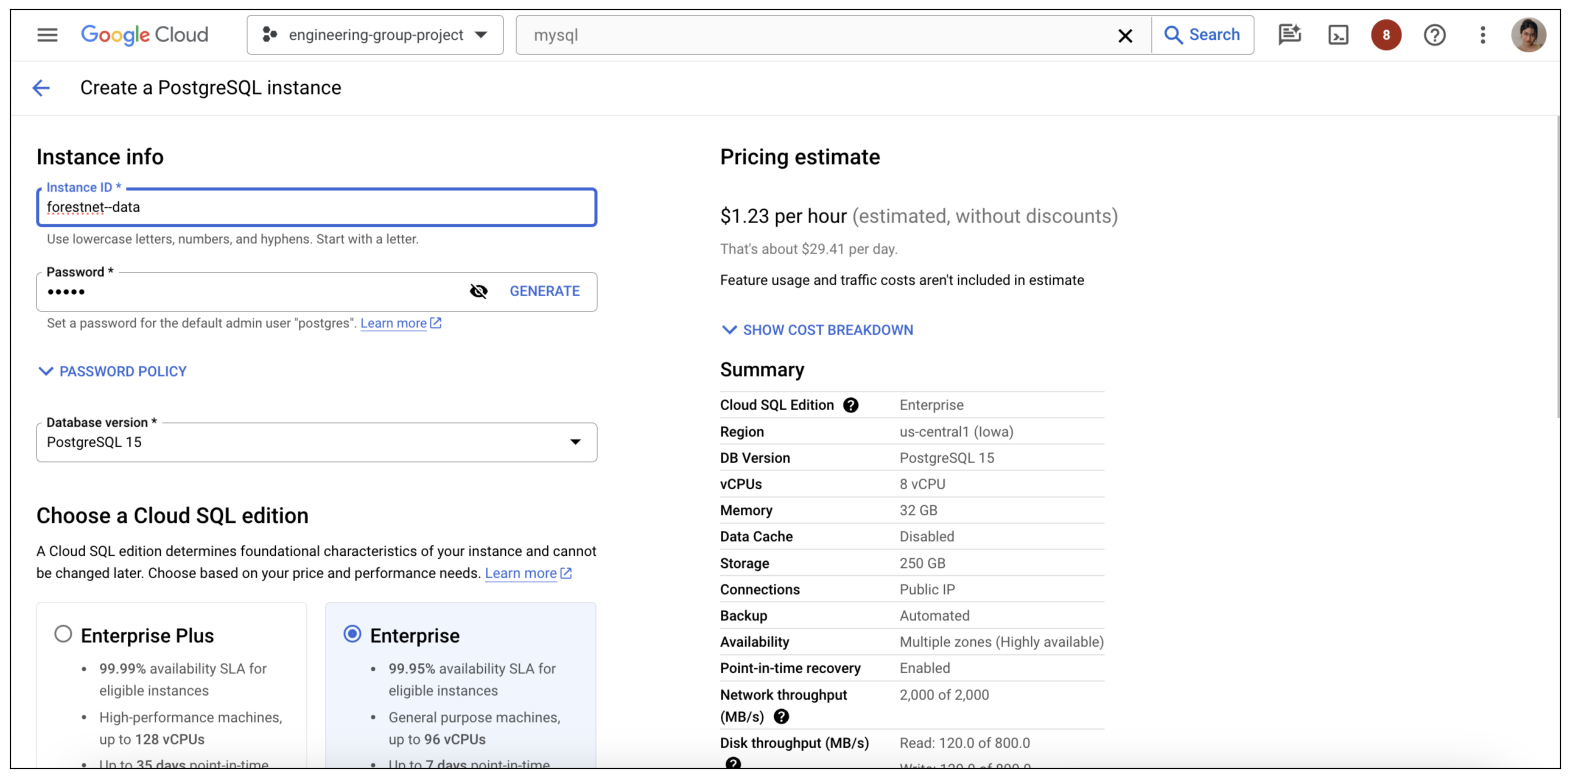

In [ ]:
# Open the image file
forestnet = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/forestnet.png')
# Set the figure size to a larger value to make the displayed image bigger
plt.figure(figsize=(20, 10))  # Adjust the width and height as needed

plt.xticks([])
plt.yticks([])

# Display the image
plt.imshow(forestnet)

In order to minimize expenses, the us-central1(Iowa) was selected as it offers a single-zone availability. The forestnet-data instance was created.

  Storing the data in a relational database like PostgreSQL involves the creation of structured tables which supports quering operations.
  In order to achieve oraganisation and facilitate efficient quering operations the next step includes the creation of tables in the database.
  A direct Interaction with the PostgreSQL database has been achieved through the connection with the Command Line Interface(CLI), which enables a more rapid, automated and direct command execution (Abdishakur 2023).
  
  Executing the following command in CLI
  **`gcloud sql connect forestnet-data --user=postgres`**, secures access to the PostgreSQL environment, indicated by the terminal prompt changing to postgres=>, which welcomes SQL statements for direct database management. Kindly note that the database is named Postgres, which is the default database and it is authorised with the user named Postgres.




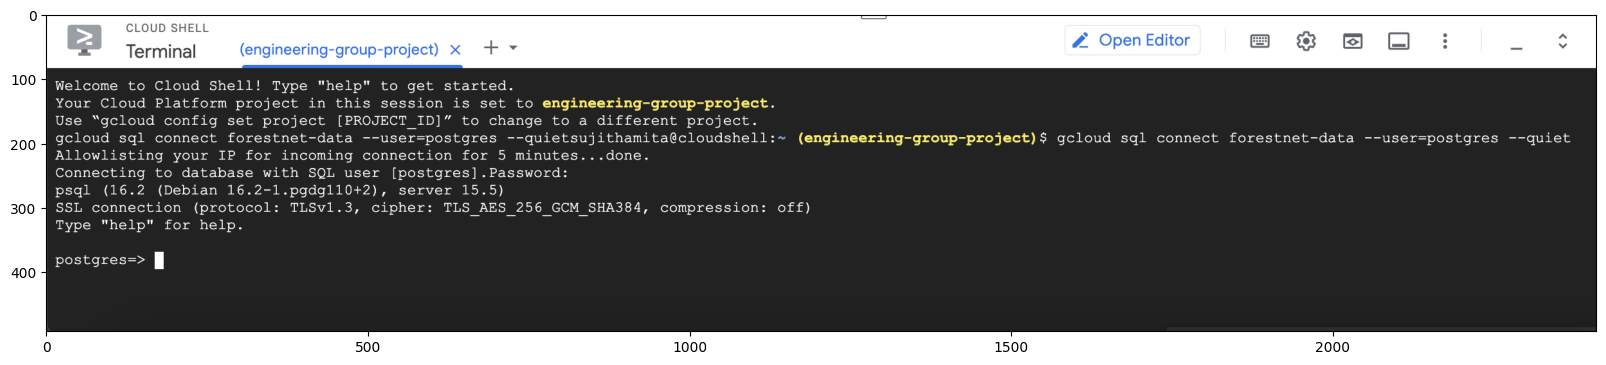

In [ ]:
image_3 = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/Picture3.1.png')
# Set the figure size to a larger value to make the displayed image bigger
plt.figure(figsize=(20, 10))  # Adjust the width and height as needed

# Display the image
plt.imshow(image_3)

  Once the access to psql client is established, the two tables for deforestaion and weather data can be created.The schemas are designed in a manner that fits the data facilitating the load and quering of data in the environment.

* **deforestation_data:**
  CREATE TABLE deforestation_data (
  label VARCHAR(255),
  merged_label VARCHAR(255),
  latitude FLOAT,
  longitude FLOAT,
  year INT,
  example_path TEXT,
  province TEXT
);

* **weather_data:**
CREATE TABLE weather_data (
    Province VARCHAR(255),
    Year INT,
    Month INT,
    Average_Temperature_Celsius FLOAT,
    Total_Rainfall_mm FLOAT
);




The gsutil tool is being used to upload the data from the Buckets to the schemas via CLI as it is considered an efficient practice for automating tasks that are complicated to accomplish through the GoogleCloud Console (Almeida 2024).

NOTE : The commands to upload **deforestaion_causes_regions.csv** file from ucl-forest bucket to the postgres table can be observed below:

1.  Extract the relevant csv file from the bucket and remove the head row for compatatbility with the schemas.


> **gsutil cat gs://ucl-forest/deforestation_causes_regions.csv | tail -n +2 | gsutil cp - gs://ucl-forest/deforestation_causes_regions_no_header.csv**



2.  Import the clean data into the PostgreSQL database.


> **gcloud sql import csv forestnet-data gs://ucl-forest/deforestation_causes_regions_no_header.csv --database=postgres --table=deforestation_data --project=engineering-group-project**




3. The **'SELECT * FROM deforestation_data;'** output verifies the succesfull import.



It can be observed below that the tables have been loaded succesfully:

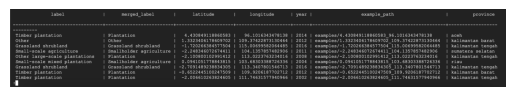

In [ ]:
#Deforestion table has been populated succesfully

deforestation_data = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/deforestation_data.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(deforestation_data)

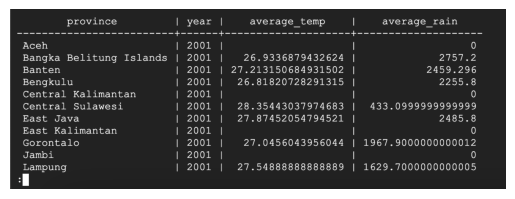

In [ ]:
#Weather table has been populated succesfully

weather_data = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/weather_data.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(weather_data)

#6.Transform

<a id="Postgres to spark"></a>
### 6.1 Connect Postgres to Spark Pipeline for merging data

Connecting PostgreSQL to Spark is beneficial as it combines Spark's ability to handle large-scale data processing with PostgreSQL's robust data storage and retrieval capabilities, enabling efficient analysis of large datasets.

**Objective:**

Inorder to facilitate effeicient data analysis, the goal is to integrate the deforestation table and the weather table. Merging these 2 tables is a crucial step as it helps us build effective visualisations. This can be done via spark or directly in postgres. In this section, we are covering the steps to effectively create a spark pipeline to create a new merged table.

#### 5.3.1 Connect to Postgres via Visual Studio Code

We first connect to the postgres instance forestnet-data with the credentials. The steps can be observed in the https://github.com/acerutti/ucl-forest-weather/blob/main/spark%20and%20Postgres.py file.

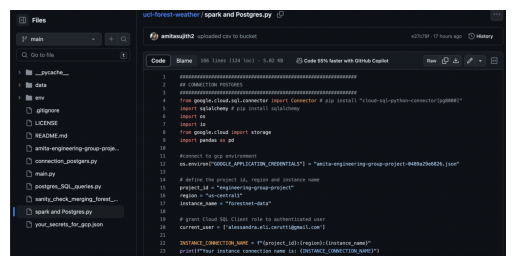

In [ ]:
spark = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/Spark-Git.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(spark)

#### 5.3.2 Import SparkSession and install JDBC Driver









In this script, we establish a connection between Spark and a PostgreSQL database using SparkSession, allowing us to read data directly from PostgreSQL tables into Spark DataFrames. Specifically, we're retrieving data from two tables, 'deforestation_data' and 'weather_data', and loading them into Spark for further processing and analysis.

Here we merge the two tables and create a merged_df which can now be converted into a csv file and uploaded into postgres. The steps can be observed at https://github.com/acerutti/ucl-forest-weather/blob/main/spark%20and%20Postgres.py



#### 5.3.3 Upload the merged csv file to PostgreSQL

The spark pipeline creates a new csv file named **'merged_deforestation_weather.csv'** which can be viewed in the data tab of github.

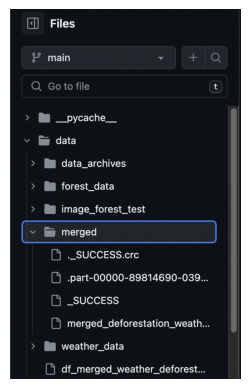

In [ ]:
data_git = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/data-git.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(data_git)

This CSV file can be uploaded to Postgres following similar steps as above.


1.   Create a Bucket named **ucl-merged.**

2.   Upload CSV to bucket via VS Code, the script can be viewed at https://github.com/acerutti/ucl-forest-weather/blob/main/spark%20and%20Postgres.py

3. Create table schema in PostgreSQL for merged data:


>  CREATE TABLE merged_deforestation_weather (
            year INT,
            province TEXT,
            label VARCHAR(255),
            merged_label VARCHAR(255),
            latitude FLOAT,
            longitude FLOAT,
            example_path TEXT,
            average_temp FLOAT,
            average_rain FLOAT
        );



4. Upload from bucket to Postgres in the CLI with the following command:


> **gcloud sql import csv forestnet-data gs://ucl-merged/merged_deforestation_weather_no_header.csv --database=postgres --table=merged_deforestation_weather --project=engineering-group-project**

4. Verify the data has been succesfully uploaded via the following command: **SELECT * FROM merged_deforestation_weather**





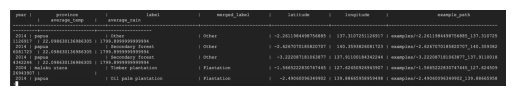

In [ ]:
# Merged table has been populated succesfully

merged_deforestation_weather= Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/merged_deforestation_weather.png')
plt.axis('off')
# Display the image
plt.imshow(merged_deforestation_weather)

The table has been succesfully populated!

<a id="Postgres"></a>
### 6.2 Alternate Method: Merge data in Postgres

We observed above the method of using spark dataframes to merge deforestation_data and weather_data tables. Alternatively, SQL Queries could be run on PostgreSQL in Google Cloud to facilitate data merging.

The script to run the same can be observed at https://github.com/acerutti/ucl-forest-weather/blob/main/postgres_SQL_queries.py



<a id="viz"></a>
#Data Visualizations

For the purpose of creating the visualisations the PostgreSQL database hosted on Google Cloud was connected to Metabase using the provided public IP address as the hostname, along with the necessary database name, username, password, and port for access.

Metabase was selected for its ease of use and approachable interface, allowing for the rapid creation of visualisations and dashboards. The key advantages of using Metabase include its simplicity in transforming data into insights, the ability to generate and share reports efficiently, and its supportive features for collaborative data exploration.

link to the dashboard can be found at https://deforestationproject.metabaseapp.com/dashboard/9-merged-deforestation-weather?tab=10-tab-1


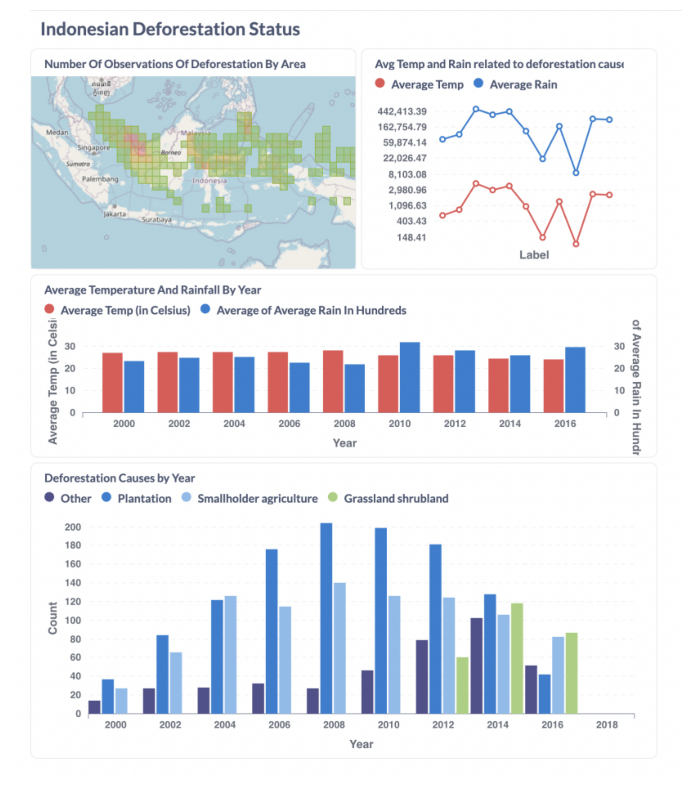

In [ ]:
# View dashboard

dashboard1= Image.open('/content/drive/MyDrive/ForestNetDataset/dashboard1.png')


# Set the figure size to a larger value to make the displayed image bigger
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed

plt.axis('off')

# Display the image
plt.imshow(dashboard1)

**Observation:**

We have a heatmap that identifies which regions are most affected by deforestation by analyzing the color density on the map. Darker shades typically represent higher counts of deforestation instances.

The bar chart *'Average Temperature and Rainfall by Year'* displays the patterns of rainfall and temperature variations from the years 2000 to 2016.

Deforestation can be caused due to multiple reasons such as excess planation, smallholder agriculture , grassland shrubland etc. The bar chart *'Deforestation causes by Year'* indicates that one of the biggest contributing factors of deforestation is plantation and the effects of these were most observed from 2008 to 2012.

It is interesting to observe that in the years that sees less rainfall and higher temperature- specifically the years 2006 and 2008, the deforestation caused is seemingly high.

# Limitations


# 8.1 Exploratory Attempt: Integrating PostgreSQL with BigQuery

As part of the data transformation step, we explored the idea of using BigQuery. Google BigQuery is a serverless, fully managed enterprise data warehouse. It utilizes BigTable and the Google Cloud Platform and is able to join, query, and analyze data of any size, from a few rows to petabytes, in just a few seconds.(referenece : https://www.sprinkledata.com/blogs/5-best-practices-for-bigquery-etl#:~:text=BigQuery%20is%20a%20fast%2C%20cost,of%20data%20through%20ANSI%20SQL.)

Why use Bigquery?

BigQuery provides a highly scalable and serverless data warehouse solution. By connecting BigQuery to PostgreSQL, we can leverage BigQuery's powerful analytics and ML capabilities on the PostgreSQL data, making it ideal for running complex queries and extracting insights from large datasets near real-time.

To upload data we need to build a CDC pipeline using datastream.Building a CDC pipeline is a straightforward way to continuously pipeline our data from postgres to Google BigQuery in near real-time making it easily available for Analytics, Reporting, and Machine Learning.

The region we sleected for building our datastream was US-Central 1 Region Iowa.

Choosing a single region for all services in a project, helps us reduce latency, as data doesn't have to travel as far, leading to faster response times and a better user experience. This also reduces data transfer costs, which are often higher for inter-regional data movement and simplifies operational logistics.

8.1.1 Create a dataset and table in Bigquery

Before building the datastream to connect Postgres to BigQuery, we need to build a dataset and a table schema. A well-defined dataset and schema ensure that the data transferred from PostgreSQL is organized and stored correctly in BigQuery and helps us effectively manage relationships.

A dataset named 'forestnet_dataset' and a schema for table named 'deforestation_data' was created.

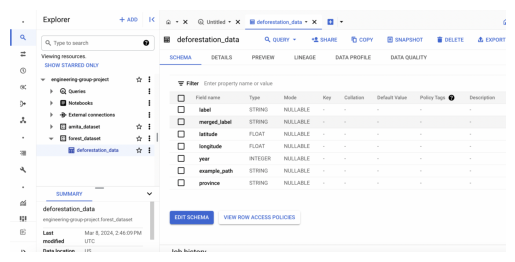

In [ ]:
from PIL import Image
bq1 = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/bigq1.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(bq1)

8.1.2 Create connection profiles

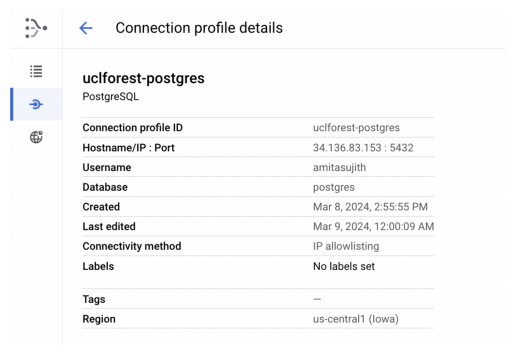

In [ ]:
#source connection profile
bq2 = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/bigq2.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(bq2)

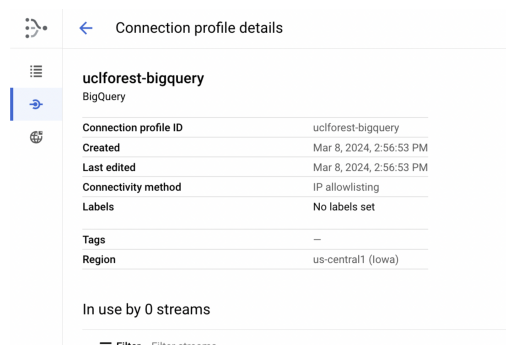

In [ ]:
#destination connection profile
bq3 = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/bigq3.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(bq3)

#### 8.1.2 Create the Datastream

**Data** streams facilitate real-time or near-real-time data ingestion into BigQuery, ensuring that the data warehouse is continuously updated with the latest information

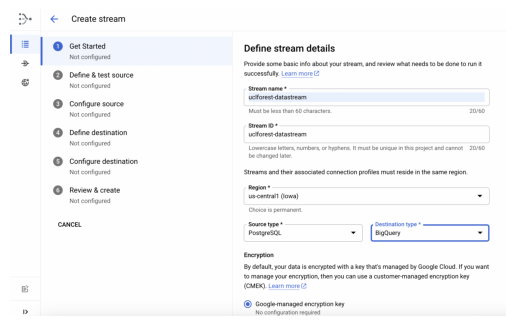

In [ ]:
#Defining stream details
bq4 = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/bigq4.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(bq4)

We created a datastream named 'uclforest-datastream'. As part of this step we also created a publication and replication slot in the CLI.

**Publication:** In PostgreSQL, a publication is a set of database changes (inserts, updates, deletes) that can be replicated. We created it by running the following command:

CREATE PUBLICATION pubforest FOR ALL TABLES;


**Replication slot:** It is a feature that ensures changes to the database are not removed before they have been replicated to all subscribers. After connecting with a user with sufficient privileges, we can create a replication slot by running the following command:

SELECT PG_CREATE_LOGICAL_REPLICATION_SLOT(‘repforest’, ‘pgoutput’);

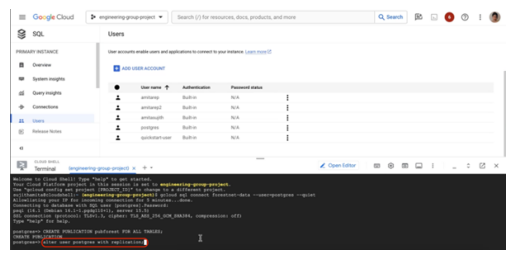

In [ ]:
#Replication slot
replication = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/replicationslot.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(publication)

Followingly, a unique a user called "ucidatastream" was generated and it was granted permission to read and access objects within this schema.


> CREATE USER ucidatastream WITH REPLICATION IN ROLE cloudsqlsuperuser LOGIN PASSWORD 'bauci';

Once the role was created, we granted the user all permissions by running the command:


> GRANT SELECT ON ALL TABLES IN SCHEMA public TO ueldatastream;
GRANT USAGE ON SCHEMA public TO ucidatastream;
ALTER DEFAULT PRIVILEGES IN SCHEMA public
GRANT SELECT ON TABLES TO ucidatastream;








Subsequently, within the web interface, configurations are being made for both the data source and the destination. This involves specifying the necessary tables to be extracted from the database, as well as setting up the destination.

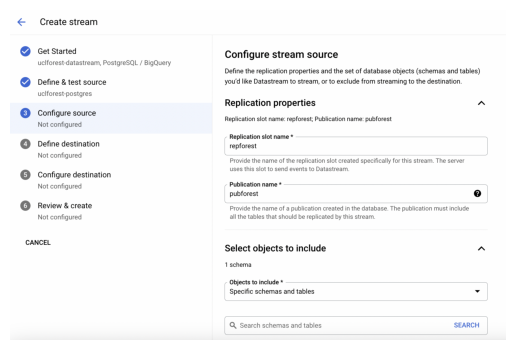

In [ ]:
#Source Configuration
source= Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/source-bq.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(source)

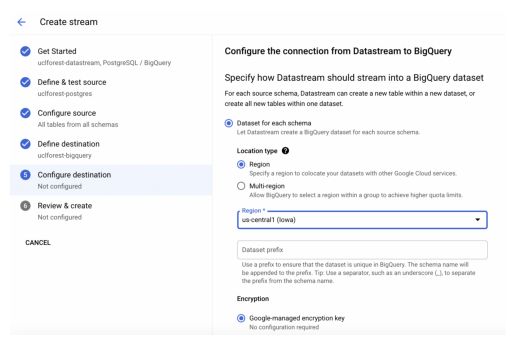

In [ ]:
#Destination Configuration
destination= Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/destination-bq.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(destination)


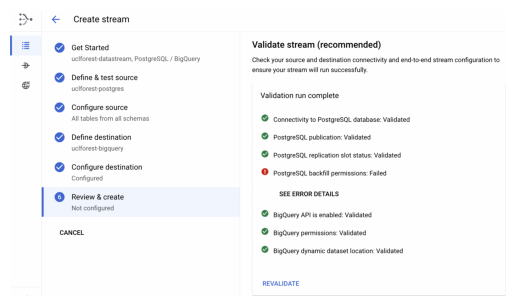

In [ ]:
#Running validation to create data stream
validation_bq = Image.open('/content/drive/MyDrive/ForestNetDataset/Screenshots/validation_bq.png')
# Set the figure size to a larger value to make the displayed image bigger

plt.axis('off')
# Display the image
plt.imshow(validation_bq)

Following this setup, the connectivity is then tested throgh the following commands :

```bash
gsutil cat gs://ucl-weather/historical_weather_data_top3.csv | tail -n +2 | gsutil cp - gs://ucl-weather/historical_weather_data_top3_no_headers.csv
gcloud sql import csv forestnet-data gs://ucl-weather/historical_weather_data_top3_no_headers.csv --database=postgres --table=weather_data --project=engineering-group-project```

Why we couldn't proceed with BigQuery

As observed above, the validation did not pass and we were unable to create the datastream due to the error: *'PostgreSQL backfill permissions: Failed'*

The error statement suggested that "One or more tables in the stream's include list weren't found or Datastream couldn't read from them. Make sure that the tables exist and that Datastream has the necessary permissions."

# Limitations for scalability

After performing transformations using Spark, data must be routed through a storage bucket prior to being loaded into the PostgreSQL database. This intermediate step may increase latency and act as a bottlneck in the pipeline especially as the volume of data scales up.

#Source Version Control(SCM)

For the operations of our project, Git has been used for version control system purposes. It was chosen based on its efficiency for collaborating, reviewing code and tracking changes (Wayne 2023). Hence a detailed view of the project's codebase can be found through the project's GitHub repository: https://github.com/acerutti/ucl-forest-weather

# Project Management

#Summary

The project successfully implemented a fully cloud-based, scalable architecture that leveraged diverse data extracting,  loading  and transformative techniques. The subsequent phase could involve creating a dynamic deforestation dashboard featuring live weather data and risk alerts, coupled with advanced analysis and machine learning for better predictions and insights to combat deforestation.

# References


•	Abdishakur H.(2023)What Is a Command-Line Interface? Built In. Available at: https://builtin.com/software-engineering-perspectives/command-line-interface (Accessed: 9 March 2024).

•	Almeida, T. A. (2024) gsutil: Command-Line Control of Google Cloud Storage, NetApp BlueXP. Available at: https://bluexp.netapp.com/blog/gsutil-command-line-control-of-google-cloud-storage (Accessed: 9 March 2024).

•	DGB Group(2024) Countries with the highest deforestation rates in the world, DGB Group. Dutch Green Business Group. Available at: https://www.green.earth/blog/countries-highest-deforestation-rates (Accessed: 10 March 2024).

•	Geodata.mit.edu. (2015). First-level Administrative Divisions, Indonesia, 2015 - GeoWeb.  Available at: https://geodata.mit.edu/catalog/stanford-ky614gm0524.
•	Hijmans and California, U. of (2015) First-level Administrative Divisions, Indonesia, 2015, GeoWeb. University of California, Berkeley. Museum of Vertebrate Zoology. Available at: https://geodata.mit.edu/catalog/stanford-ky614gm0524 (Accessed: 10 March 2024).

•	Irvin, J., Sheng, H., Ramachandran, N., Johnson-Yu, S., Zhou, S., Story, K.T., Rustowicz, R., Elsworth, C.W., Austin, K. and Ng, A.Y. (2020). ForestNet: Classifying Drivers of Deforestation in Indonesia using Deep Learning on Satellite Imagery. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.2011.05479.

•	LogicMonitor (2023) What is a bucket in GCP? GCP buckets explained, LogicMonitor. Available at: https://www.logicmonitor.com/blog/what-is-a-bucket-in-gcp-gcp-buckets-explained (Accessed: 10 March 2024).
•	Risser MD(2024), Collins WD, Wehner MF, O’Brien TA, Huang H, Ullrich PA. Anthropogenic aerosols mask increases in US rainfall by greenhouse gases.
Nature Communications.;15(1):1318. doi: 10.1038/s41467-024-45504-8

•	Ritchie (2023) Deforestation and Forest Loss, Our World in Data. Available at: https://ourworldindata.org/deforestation#:~:text=Globally%20we%20deforest%20around%20ten%20million%20hectares%20of%20forest%20every%20year.&text=That’s%20an%20area%20the%20size,deforestation%20occurs%20in%20the%20tropics. (Accessed: 10 March 2024).
•	Stanford ML Group(2020)ForestNet: Classifying Drivers of Deforestation in Indonesia using Deep Learning on Satellite Imagery. Available at: https://stanfordmlgroup.github.io/projects/forestnet/ (Accessed: 10 March 2024).

•	VMWARE(2024). Available at: https://www.vmware.com/topics/glossary/
content/cloud-scalability.html#:~:text=Cloud%20scalability%20in%20cloud%20computing,its%20exploding%20popularity%20with%20businesses. (Accessed: 10 March 2024).

•	Wayne, R. (2023) Unlocking the Power of Git: The Benefits of Using Git for Source Code Management, Medium. Medium. Available at: https://medium.com/@rick.wayne.2022/unlocking-the-power-of-git-the-benefits-of-using-git-for-source-code-management-8e4eae6782c7#:~:text=Git%20provides%20a%20complete%20version,to%20identify%20and%20resolve%20issues. (Accessed: 10 March 2024).

•	 Google (2024) Google Cloud. Why Google Cloud?. Available at: https://cloud.google.com/why-google-cloud?hl=en (Accessed: 9 March 2024).

In [ ]:
import nbformat

# Load the current notebook
notebook_path = '/content/drive/MyDrive/ForestNetDataset/DE_Forest_Net_Draft.ipynb'  # Adjust this to the path of your notebook
with open(notebook_path, 'r', encoding='utf-8') as nb_file:
    nb_contents = nbformat.read(nb_file, as_version=4)

# Initialize word count
total_word_count = 0

# Iterate through each cell in the notebook
for cell in nb_contents['cells']:
    if cell['cell_type'] == 'markdown':
        total_word_count += len(cell['source'].split())
    elif cell['cell_type'] == 'code':
        # Count words in code comments
        comments = [line for line in cell['source'].split('\n') if line.strip().startswith('#')]
        comment_text = ' '.join(comments)
        total_word_count += len(comment_text.split())

# Print the total word count
print(f"Total Word Count: {total_word_count}")


Total Word Count: 5080


In [ ]:
import nbformat

# Load the current notebook
notebook_path = '/content/drive/MyDrive/ForestNetDataset/DE_Forest_Net_Draft.ipynb'  # Adjust this to the path of your notebook
with open(notebook_path, 'r', encoding='utf-8') as nb_file:
    nb_contents = nbformat.read(nb_file, as_version=4)

# Initialize word count
total_word_count = 0
skip_cell_content = "#skip_word_count"

# Iterate through each cell in the notebook
for cell in nb_contents['cells']:
    if cell['cell_type'] == 'markdown':
        # Check if cell contains the skip flag
        if skip_cell_content not in cell['source']:
            total_word_count += len(cell['source'].split())
    elif cell['cell_type'] == 'code':
        # Check if cell contains the skip flag
        if skip_cell_content not in cell['source']:
            # Count words in code comments
            comments = [line for line in cell['source'].split('\n') if line.strip().startswith('#')]
            comment_text = ' '.join(comments)
            total_word_count += len(comment_text.split())
total_word_count = total_word_count- 269 - 56 #references & table contetns

# Print the total word count
print(f"Total Word Count: {total_word_count}")


Total Word Count: 4705


#Appendix

In [ ]:
#The following code provides
image_names = [
    "-0.002226324002905_109.97159881327198",
    "-0.025186616919319_113.71975529073988",
    "-0.03027428009349_101.59766149324824",
    "-0.22946911191326_101.62682788208392",
    "-0.23142888714857_99.87426629402542"
]

# Function to find matching row in DataFrame for given image name
def find_matching_row(gdf, image_name):
    # Split image name into latitude and longitude
    lat_str, long_str = image_name.split('_')
    latitude = float(lat_str)
    longitude = float(long_str)

    # Find row in DataFrame where latitude and longitude match
    match = df[(df['latitude'].astype(str).str.contains(lat_str)) & (df['longitude'].astype(str).str.contains(long_str))]
    return match

# Iterate through image names and find matching rows
matches = []
for image_name in image_names:
    match = find_matching_row(df, image_name)
    if not match.empty:
        matches.append((image_name, match.index.tolist()))

matches

[('-0.002226324002905_109.97159881327198', [392]),
 ('-0.025186616919319_113.71975529073988', [2502]),
 ('-0.03027428009349_101.59766149324824', [1513]),
 ('-0.22946911191326_101.62682788208392', [162]),
 ('-0.23142888714857_99.87426629402542', [2584])]